- Заменить используемую сеть на менее "глубокую" (меняем на VVG-16)
- Увеличить размер изображения, задав большее значение чем 256 (берем 512)
- Изменить соотношение стиля и контента
- Сгенерировать стилизованное изображение, используя другие, выбранные вами изображения
# Специальные требования:

- Ноутбук должен выполняться в Colab или в локальном Jupyter нотбуке. Изображения должны быть приложены (например, вклеены в текутовую ячейку), либо должны быть даны ссылки на них (URL)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.models import vgg16, VGG16_Weights
import copy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [3]:
# Размер изображений
imsize = 512

loader = transforms.Compose([
    transforms.Resize(imsize),  # масштабируем с сохранением соотношения сторон
    transforms.CenterCrop(imsize), # обрежем края чтобы получить квадратное изображение
    transforms.ToTensor()])  # преобразуем в Torch Tensor

In [4]:
# ф-я загрузки и преобразования картинок
def image_loader(image_name):
    image = Image.open(image_name).convert('RGB')
    image = loader(image).unsqueeze(0)   # добавляем 4е измерение
    return image.to(device, torch.float)

In [6]:
# загружаем картинки
style_img = image_loader("./data/images/style.jpg")
content_img = image_loader("./data/images/content.jpg")
# контроль соответствия размеров изображений
assert style_img.size() == content_img.size()

In [7]:
unloader = transforms.ToPILImage()  # Преобразуем в картинку PIL
plt.ion()

In [8]:
# ф-я вывода изображений
def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    # выводим название если но есть
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # Дадим графику обновиться

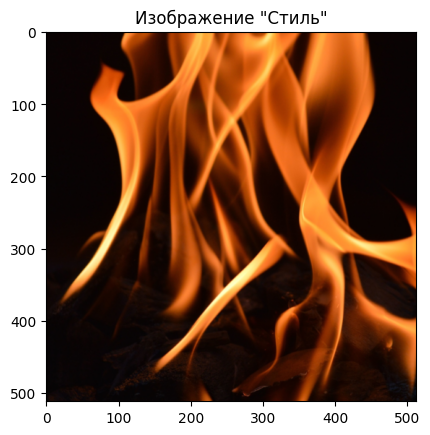

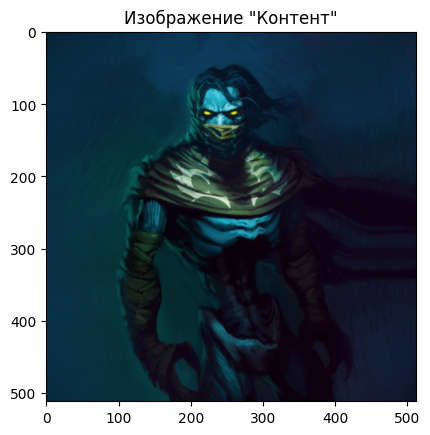

In [9]:
# выводим стилевую и контентную картинки
plt.figure()
imshow(style_img, title='Изображение "Стиль"')

plt.figure()
imshow(content_img, title='Изображение "Контент"')

In [10]:
class ContentLoss(nn.Module):
    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
    # лосс-функция по контенту
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [11]:
# ф-я матрицы Грама
def gram_matrix(input):
    a, b, c, d = input.size()   # смотрим размерности (в 4-х измерениях)
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())  # рассчитать произведение матриц чтобы получить матрицу Грама
    # нормализуем значения матрицы Грама
    return G.div(a * b * c * d)

In [12]:
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
    # ф-я потерь для стиля
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [13]:
# загрузка предобученной модели VGG-16 с весами по умолчанию
cnn = vgg16(weights=VGG16_Weights.DEFAULT).features.eval()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 81.1MB/s]


In [14]:
# нормализация входных изображений
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

In [15]:
# упаковочный класс, чтобы картинку было легче передать в объект ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)
    def forward(self, img):
        # нормализуем изображение ``img``
        return (img - self.mean) / self.std

In [16]:
# названия слоев, где мы будем рассчитывать расхождение по контенту (один слой)
# это 4й сверточный уровень
content_layers_default = ['conv_4']

# названия слоев, где мы будем рассчитывать расхождение по стилю (5 слоев)
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
# ф-я переименования
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # модуль чтобы нормализоавть изображения
    normalization = Normalization(normalization_mean, normalization_std)

    content_losses = []
    style_losses = []
    model = nn.Sequential(normalization)

    i = 0  # пройдемся по элементам в исходной нейросети и дадим им имена
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        # Добавим очередной модуль в нашу Sequential-модель
        # передаем название и слой
        model.add_module(name, layer)

        # если имя слоя фигурировало в content_layers то добавляем слой ContentLoss
        if name in content_layers:
            # если к последнему слою нужно пристыковать контент-лосс, сделаем это
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        # если имя слоя фигурировало в style_layers то добавляем слой StyleLoss
        if name in style_layers:
            # а если имя слоя в списке стиль-лоссов, добавим после него соответствующий лосс
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # все слои которые идут после последнего добавленного контент-лосса или стиль-лосса
    # нам будут не нужны, их можно отбросить
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]
    return model, style_losses, content_losses

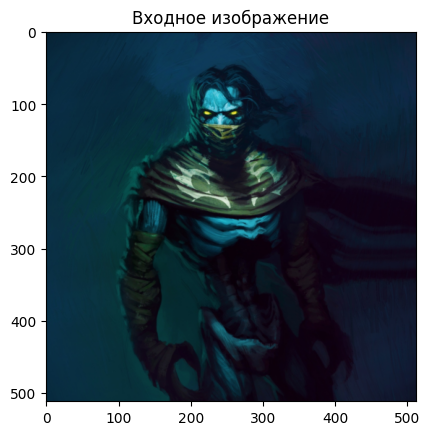

In [17]:
input_img = content_img.clone()
# input_img = style_img.clone()
plt.figure()
imshow(input_img, title='Входное изображение')

In [18]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img])   # оптимизатор LBFGS
    return optimizer

In [19]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=10000, content_weight=100):

    print('Построение модели переноса стиля..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # Укажем, какой объект мы будем оптимизировать (включить параметр requires_grad fields)
    input_img.requires_grad_(True)   # считаем градиенты
    # Переключим модель в режим исполнения, чтобы заморозить слои вроде dropout или батч нормализации normalization layers
    model.eval()
    # заморозим все параметры нейросети
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)   # оптимизатор

    print('Оптимизируем картинку..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # скорректируем значения входного изображения
            with torch.no_grad():
                input_img.clamp_(0, 1)   # все пиксели ограничиваются значениями от 0 до 1

            optimizer.zero_grad() # обнуляем градиенты оптимизатора
            model(input_img) # отправить картинку в модель

            # Посчитаем расхождение изображений по стилю и содержимому
            style_score = 0
            content_score = 0
            # считаем лоссы
            for sl in style_losses: style_score += sl.loss
            for cl in content_losses: content_score += cl.loss

            style_score *= style_weight # Домножаем каждую компоненту лосса на заданный вес
            content_score *= content_weight

            loss = style_score + content_score
            # по этому значению осуществляем обратное распространение ошибки (обратно по сети, вплоть до изображения)
            loss.backward()

            run[0] += 1   # инкрементируем счетчик шагов оптимизации
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score
        # делается шаг оптимизатора и на объекте выполняем функцию closure
        optimizer.step(closure)

    # и в последний раз вернем изображение в диапазон
    with torch.no_grad():
        input_img.clamp_(0, 1)   # все пиксели ограничиваются значениями от 0 до 1

    return input_img

Построение модели переноса стиля..


/usr/local/lib/python3.10/dist-packages/torch/utils/_device.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Оптимизируем картинку..
run [50]:
Style Loss : 1036.630249 Content Loss: 822.135803

run [100]:
Style Loss : 377.503845 Content Loss: 861.823486

run [150]:
Style Loss : 271.584442 Content Loss: 800.671204

run [200]:
Style Loss : 234.786285 Content Loss: 777.849121

run [250]:
Style Loss : 197.376785 Content Loss: 790.051575

run [300]:
Style Loss : 169.345184 Content Loss: 755.922241

run [350]:
Style Loss : 155.522812 Content Loss: 753.251099

run [400]:
Style Loss : 152.544037 Content Loss: 731.302490

run [450]:
Style Loss : 756.947205 Content Loss: 974.523193

run [500]:
Style Loss : 208.455811 Content Loss: 793.612549



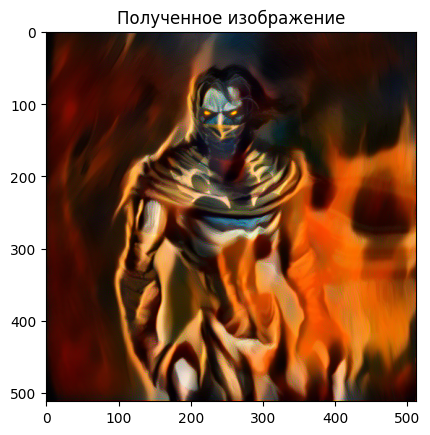

In [20]:
# меняем веса и передаем в функцию
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=500,
                            style_weight=1000000, content_weight=100)

plt.figure()
imshow(output, title='Полученное изображение')

plt.ioff()
plt.show()   # получаем картинку